In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, rdmolops, AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import MACCSkeys


from scipy.stats import pearsonr


# sklearn ML models
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import svm

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import  LGBMRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity='all'


/Users/liugrp_m/anaconda3/lib/python3.11/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
df = pd.read_csv('../01-database-preprocessing-1203dp-to-1115dp/raw/atom_number_wH_sort_1115-backbone-correction-newSMILES.csv')
df.head()

,Nickname,bandgap(eV),c_smiles,newSMILES,Ref.No
0,P3HT,1.93,CCCCCCc1cc(C)sc1C,Cc1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C)c(s1)-c1cc(C...,S10
1,P3HST,1.82,CCCCCCSc1cc(C)sc1C,CSc1cc(sc1C)-c1sc(cc1SC)-c1sc(cc1SC)-c1sc(cc1S...,S123
2,POPT,1.76,CCCCCCCCc1ccc(-c2cc(C)sc2C)cc1,Cc1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c1cc(c(s1)-c...,S126
3,PT-C1,1.92,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(C)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1cc(C(=O)OC)c(s1)...,S122
4,PT-C2,1.89,CCCCC(CC)COC(=O)c1cc(C)sc1-c1ccc(-c2ccc(C)s2)s1,COC(=O)c1cc(C)sc1-c1ccc(s1)-c1ccc(s1)-c1cc(C(=...,S122


# experimental values

In [3]:
df_exp = df['bandgap(eV)']
df_exp

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1110    1.68
1111    1.65
1112    1.66
1113    1.52
1114    1.73
Name: bandgap(eV), Length: 1115, dtype: float64

# DFT-B3LYP

In [4]:
df = pd.read_csv('./DFT/scf-6-31gs.csv')
scf = df[['HOMO-LUMO(eV)']]
scf

,HOMO-LUMO(eV)
0,2.78726
1,2.72032
2,3.19979
3,2.69964
4,2.66372
...,...
1110,1.93038
1111,1.93065
1112,2.04439
1113,1.94561


# TDDFT

In [5]:
df = pd.read_csv('./DFT/tddft-6-31gs.csv')
# df
s1 = df[['S1']]
s1

,S1
0,2.4954
1,2.3866
2,2.7435
3,2.3922
4,2.3712
...,...
1110,1.6818
1111,1.6425
1112,1.8037
1113,1.7335


In [6]:
df[np.isnan(df).any(axis=1)==True]


,S1,S2,S3,S4,S5
266,2.1095,NaN,NaN,NaN,NaN
348,1.8407,NaN,NaN,NaN,NaN
683,1.9067,NaN,NaN,NaN,NaN
691,NaN,NaN,NaN,NaN,NaN
896,1.5486,NaN,NaN,NaN,NaN
908,2.0977,NaN,NaN,NaN,NaN
1035,1.7128,NaN,NaN,NaN,NaN
1105,1.7418,NaN,NaN,NaN,NaN
1111,1.6425,NaN,NaN,NaN,NaN


# drop sp3-N polymers + donor-692

In [8]:
sp3_N_list = [  24,   44,  191,  201,  206,  209,  251,  317,  318,  332,  374,
             381,  388,  454,  913,  931,  936, 1006]
drop_list = sp3_N_list+[691]
print('Total data points: ', 1115-len(drop_list))

Total data points:  1096


In [9]:
df_dft = scf[~scf.index.isin(drop_list)].reset_index(drop=True)
df_tddft = s1[~s1.index.isin(drop_list)].reset_index(drop=True)
df_exp = df_exp[~df_exp.index.isin(drop_list)].reset_index(drop=True)


In [10]:
feature = pd.concat([df_dft, df_tddft], axis=1)
feature.columns=['HOMO-LUMO(eV)', 'S1']
feature

,HOMO-LUMO(eV),S1
0,2.78726,2.4954
1,2.72032,2.3866
2,3.19979,2.7435
3,2.69964,2.3922
4,2.66372,2.3712
...,...,...
1091,1.93038,1.6818
1092,1.93065,1.6425
1093,2.04439,1.8037
1094,1.94561,1.7335


In [11]:
feature[np.isnan(feature).any(axis=1)==True]


,HOMO-LUMO(eV),S1


# Pearson correlation

In [12]:
feature.corr()

,HOMO-LUMO(eV),S1
HOMO-LUMO(eV),1.00000,0.98621
S1,0.98621,1.00000


# Parity plot

In [13]:

def linear_fit(data, x_property, y_property, x_label, y_label):
    Y = data[y_property]
    X = data[[x_property]]

    model = LinearRegression()
    model.fit(X,Y)
    a  = model.intercept_ #截距 
    b = model.coef_ #回归系数
    score = model.score(X,Y)

    Y_pred = model.predict(X)
    xmin = X.min()
    xmax = X.max()

    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    plt.plot((xmin,xmax), (xmin*b[0]+a,xmax*b[0]+a), ls='--', c='black', linewidth=3, label=f"$R^2$={round(score,3)}")
    plt.legend(fontsize=32)

    plt.scatter(X, Y)

    ax.tick_params(direction='in', width=2)
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='y', pad=10)
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    for spine in ax.spines.values():
        spine.set_linewidth(2)

    plt.xlabel(x_label, fontsize=38, font="arial", labelpad=10)
    plt.ylabel(y_label, fontsize=38, font="arial", labelpad=10)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)
    plt.gca().tick_params(axis='both', length=10, width=2)


    plt.show()

In [14]:
feature_list = ['HOMO-LUMO(eV)', 'S1']
label_list = ['$E_{gap}^{B3LYP}$ (eV)', 
              '$E_{S1}^{B3LYP}$ (eV)']

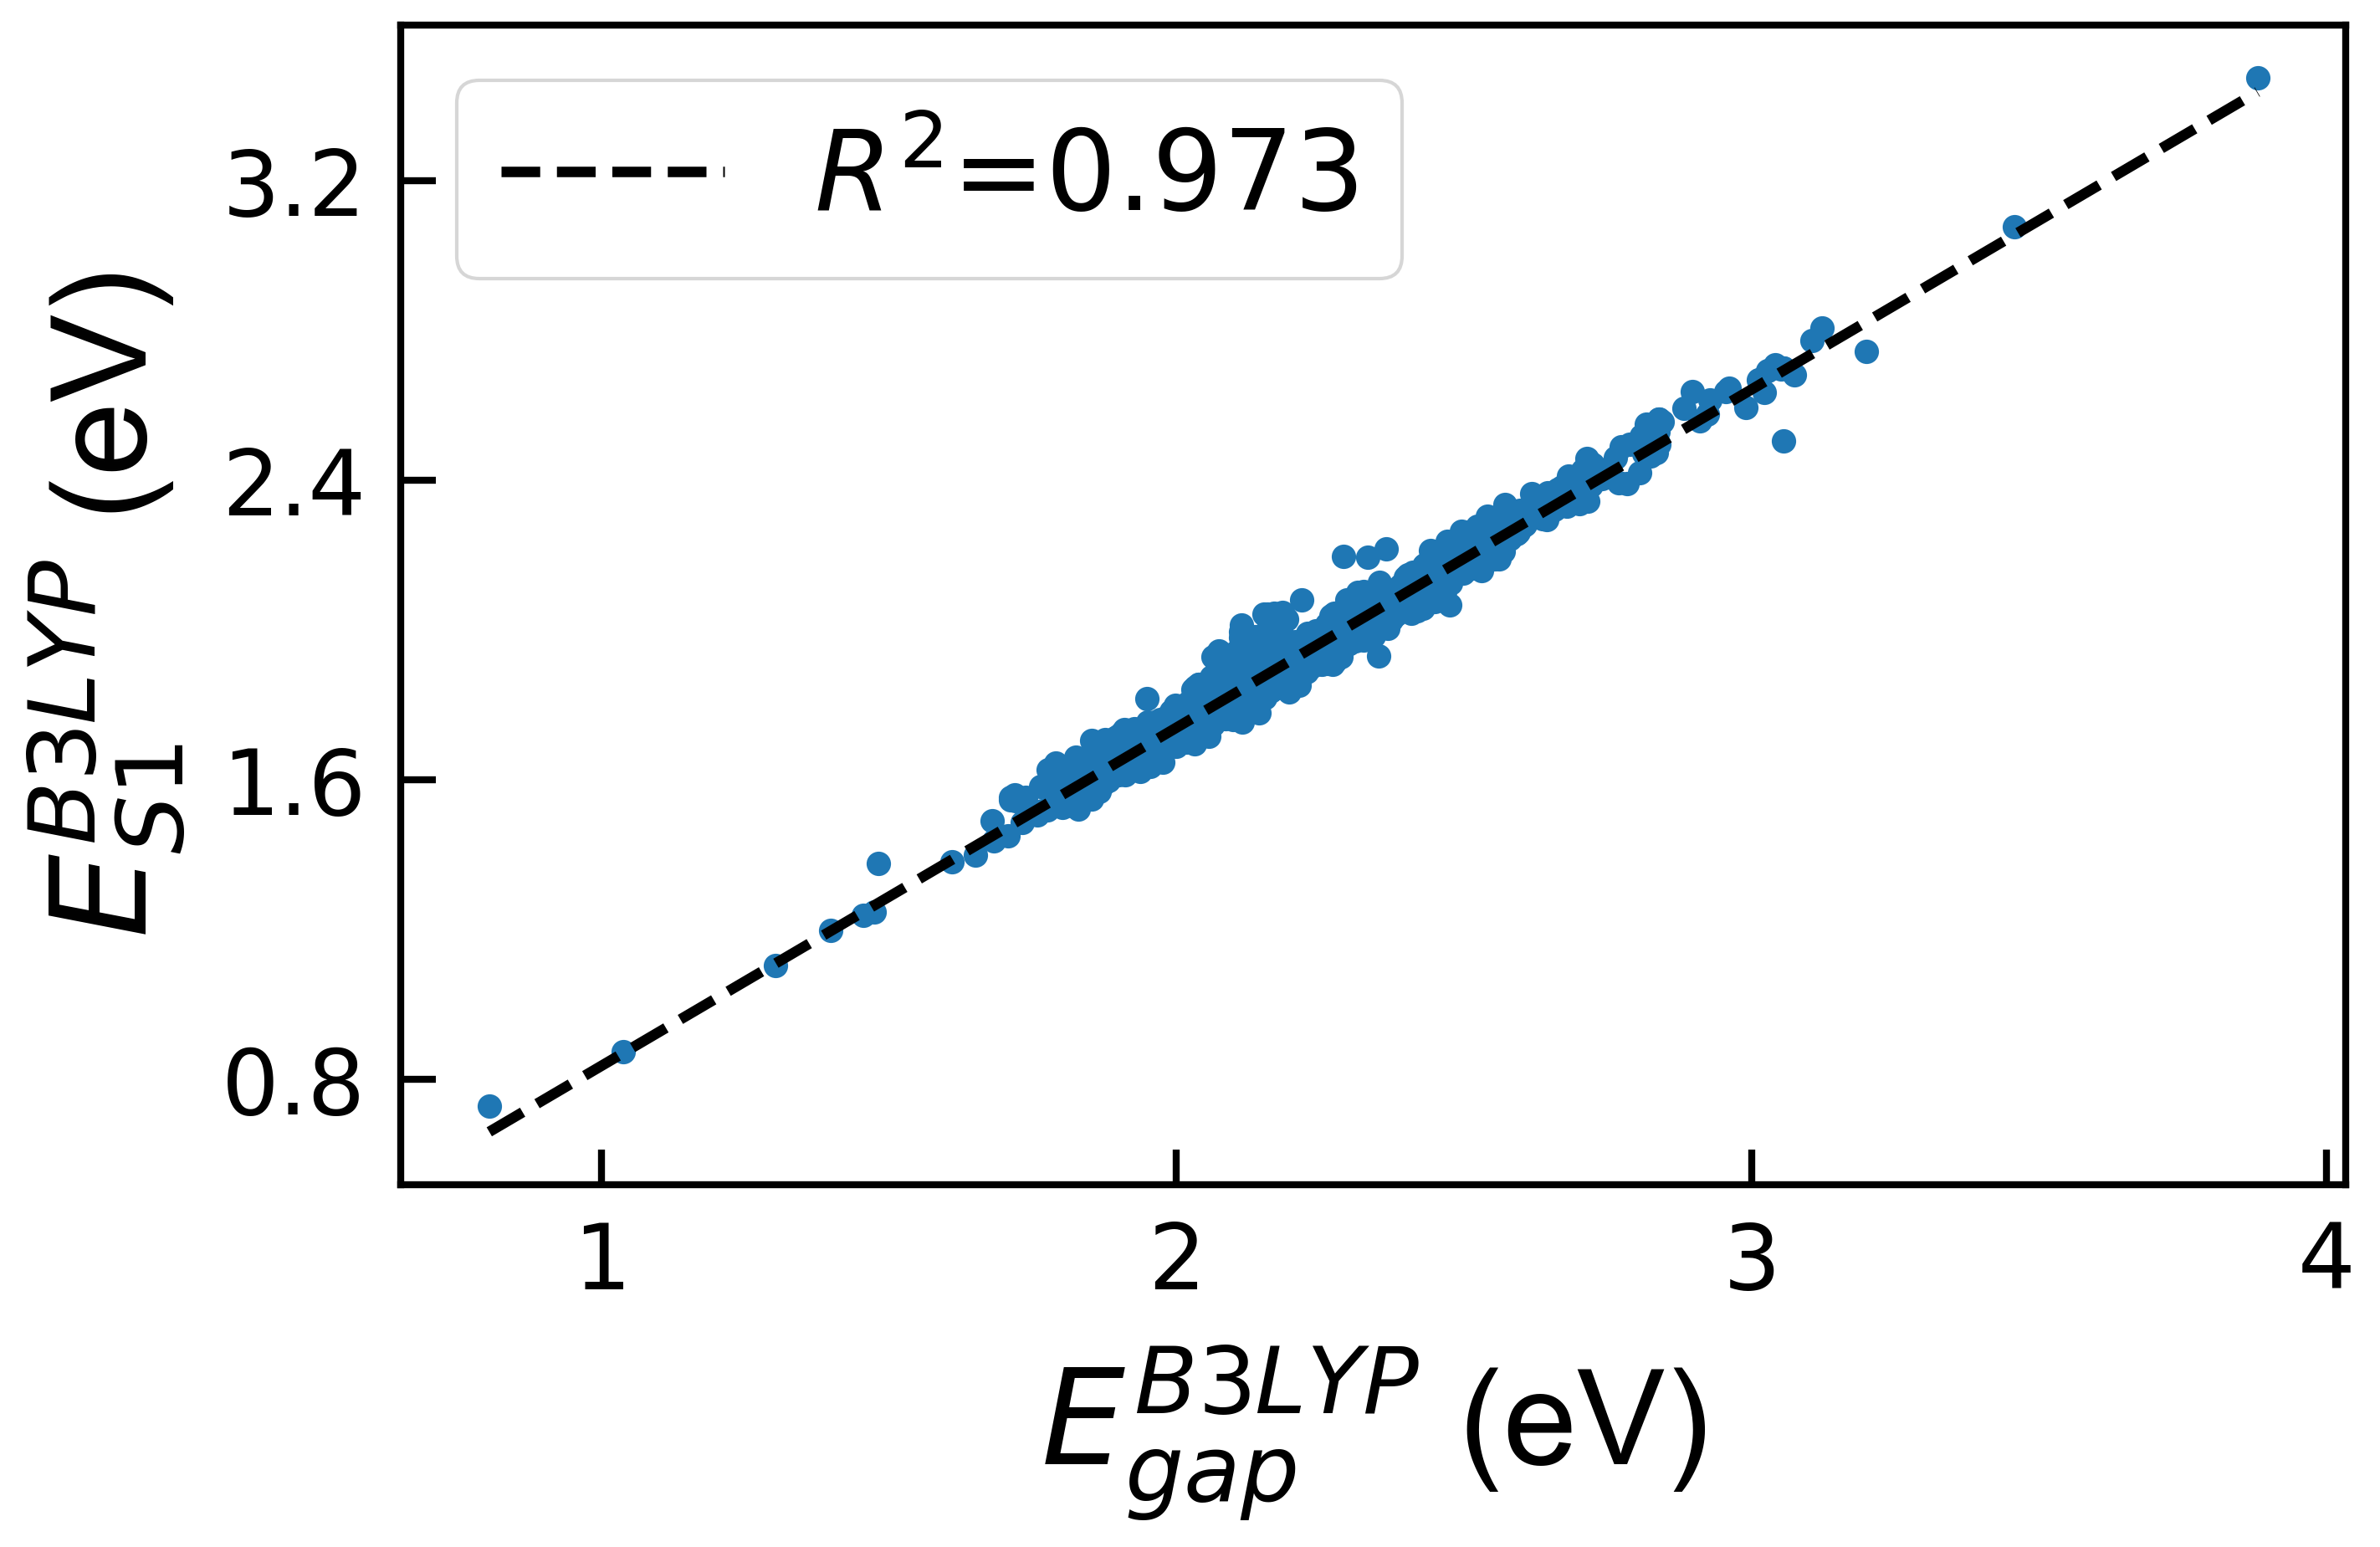

In [15]:
x_idx=0
y_idx=1
linear_fit(feature, feature_list[x_idx], feature_list[y_idx], label_list[x_idx], label_list[y_idx])

In [16]:
feature[feature['S1']<1]

,HOMO-LUMO(eV),S1
1074,0.804641,0.7292
1085,1.037570,0.8736


# Linear fitting

In [17]:
y = df_exp
y

0       1.93
1       1.82
2       1.76
3       1.92
4       1.89
        ... 
1091    1.68
1092    1.65
1093    1.66
1094    1.52
1095    1.73
Name: bandgap(eV), Length: 1096, dtype: float64

In [18]:
X = df_tddft
X

,S1
0,2.4954
1,2.3866
2,2.7435
3,2.3922
4,2.3712
...,...
1091,1.6818
1092,1.6425
1093,1.8037
1094,1.7335


## a. metrics

In [19]:
def acc(y_test,y_pred):
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = MSE ** 0.5
    R2 = r2_score(y_test,y_pred)
#     p = pearsonr(y_test,y_pred.reshape(-1,1)) # y_pred shape = (xxx,)
    r, p_value = pearsonr(y_test,y_pred) # y_pred shape = (xxx,)
    MAE = mean_absolute_error(y_test,y_pred)
    return RMSE, R2, r, MAE

## b. fitting

In [20]:
model = LinearRegression()
model.fit(X,y)
a  = model.intercept_ #截距 
b = model.coef_ #回归系数
print("最佳拟合线:截距",a,",回归系数：",b)

score = model.score(X,y) 
print(score)

最佳拟合线:截距 0.6751505080868874 ,回归系数： [0.5341181]
0.447977288014171


In [21]:
y_pred = model.predict(X)

scores = []
RMSE, R2, r, MAE = acc(y,y_pred)
scores.append([RMSE, R2, r, MAE])

scores_df = pd.DataFrame(scores, columns = ['RMSE', 'R2', 'r', 'MAE'])
scores_df.round(3)

,RMSE,R2,r,MAE
0,0.153,0.448,0.669,0.12
